In [1]:
import NotebookImport
from Imports import *

importing IPython notebook from Imports

In [2]:
import seaborn as sns
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

In [3]:
matched_rna = pd.read_hdf('/data_ssd/RNASeq_2015_04_02.h5', 'matched_tn')

In [4]:
dx_rna = binomial_test_screen(matched_rna, fc=1.)
dx_rna = dx_rna[dx_rna.num_dx > 300]

In [261]:
standardize = lambda s: s.sub(s.mean(1),0).div(s.std(1), 0)

In [134]:
df = matched_rna.sub(matched_rna.mean(1),0).div(matched_rna.std(1),0)
dx = df.xs('01',1,1) - df.xs('11',1,1)

In [275]:
df_s = pd.concat([standardize(matched_rna.ix[:, ti(codes==c)]) 
                 for c in codes.unique()], axis=1)
dx = df_s.xs('01',1,1) - df_s.xs('11',1,1)

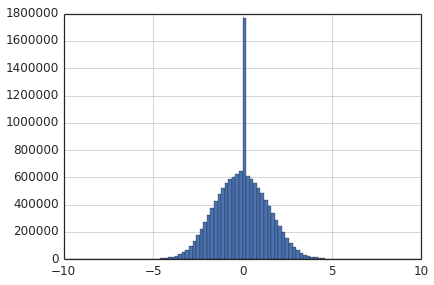

In [276]:
dx.stack().clip(-10,10).hist(bins=100)

In [135]:
mr = dx.rank(pct=True).mean(1)

In [136]:
from scipy.special import expit

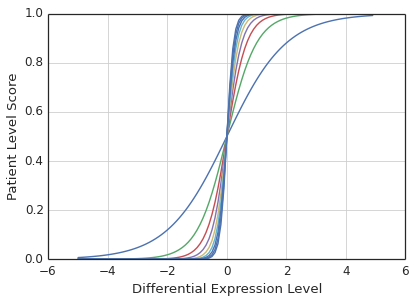

In [297]:
fig, ax = subplots()
for i in range(1,10):
    pd.Series(expit(np.arange(-5,5,.1)*i), np.arange(-5,5,.1)).plot(ax=ax)
ax.set_ylabel('Patient Level Score')
ax.set_xlabel('Differential Expression Level')

In [279]:
sig = (dx*2).apply(expit)
sig_weight = sig.mean(1).order().dropna()

In [280]:
pearson_pandas(sig_weight, dx_rna.frac)['rho']

0.9952350328187739

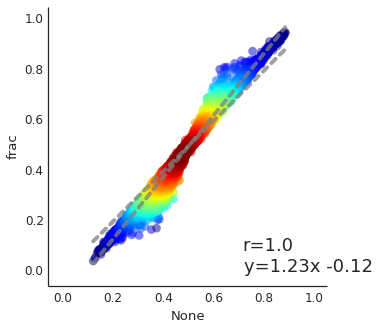

In [281]:
plot_regression(sig_weight, dx_rna.frac, density=True, rad=.1)

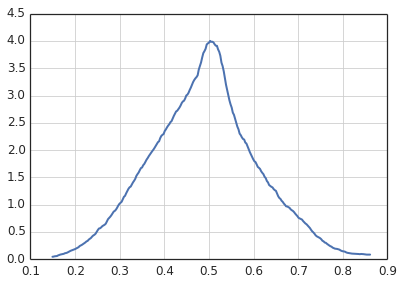

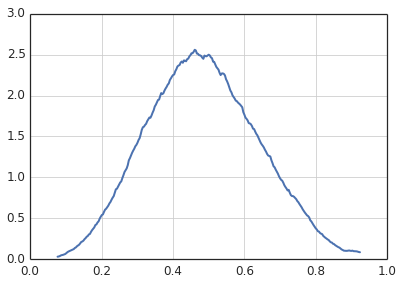

In [282]:
draw_dist(sig_weight)
draw_dist(dx_rna.frac)

In [283]:
gs2 = gene_sets.ix[dx_rna.index].fillna(0)

In [284]:
rr = screen_feature(sig_weight, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * sig_weight).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

In [285]:
rr.ix[ti(fp > .5)].join(fp).sort('p').head()

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_CELL_CYCLE,330.04,9.43e-74,1.25e-70,0.62
REACTOME_CELL_CYCLE_MITOTIC,256.85,8.35e-58,5.55e-55,0.63
REACTOME_DNA_REPLICATION,232.64,1.58e-52,7.03e-50,0.66
REACTOME_MITOTIC_M_M_G1_PHASES,204.42,2.27e-46,7.53e-44,0.66
REACTOME_METABOLISM_OF_RNA,160.06,1.10e-36,2.93e-34,0.58


In [286]:
rr.ix[ti(fp < .5)].join(fp).sort('p').head(10)

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_SIGNALING_BY_GPCR,48.45,3.39e-12,6.27e-11,0.47
KEGG_FATTY_ACID_METABOLISM,48.22,3.82e-12,6.95e-11,0.34
REACTOME_BIOLOGICAL_OXIDATIONS,46.64,8.51e-12,1.43e-10,0.41
REACTOME_PHASE1_FUNCTIONALIZATION_OF_COMPOUNDS,43.85,3.55e-11,5.62e-10,0.38
REACTOME_GPCR_DOWNSTREAM_SIGNALING,43.13,5.11e-11,7.91e-10,0.47
KEGG_DRUG_METABOLISM_CYTOCHROME_P450,39.36,3.52e-10,5.08e-09,0.39
KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,39.13,3.96e-10,5.62e-09,0.37
KEGG_CALCIUM_SIGNALING_PATHWAY,37.00,1.18e-09,1.56e-08,0.43
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,34.78,3.69e-09,4.72e-08,0.44


In [287]:
def fig_1f(vec, ax):
    v = pd.concat([vec, 
                   vec.ix[ti(gs2['REACTOME_CELL_CYCLE']>0)],
                   vec.ix[ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0)]])

    v1 = pd.concat([pd.Series('All Genes', vec.index), 
                    pd.Series('Cell Cycle',
                              ti(gs2['REACTOME_CELL_CYCLE']>0)),
                    pd.Series('Fatty Acid\nMetabolism', 
                              ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0))])
    v1.name = ''
    v.name = 'Fraction Overexpressed'
    violin_plot_pandas(v1, v, ann=None, ax=ax)
    prettify_ax(ax)
    ax.spines['bottom'].set_visible(False)
    ax.axhline(.5, color='grey', lw=2, ls='--')
    return ax

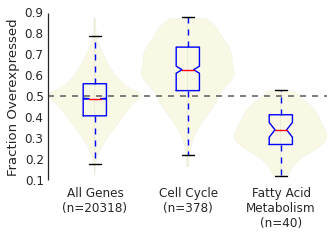

In [288]:
fig, ax = subplots(1,1, figsize=(5,3))
fig_1f(sig_weight, ax)

In [291]:
d2 = matched_rna.ix[:, ti(codes=='PRAD')].dropna()
df = d2.sub(d2.mean(1),0).div(d2.std(1),0)
dx = df.xs('01',1,1) - df.xs('11',1,1)
sig = (dx*2).apply(expit)
sig_weight = sig.mean(1).order().dropna()
dx_brca = binomial_test_screen(d2, fc=1.)

In [289]:
d2 = df_s.ix[:, ti(codes!='PRAD')].dropna()
df = d2.sub(d2.mean(1),0).div(d2.std(1),0)
dx = df.xs('01',1,1) - df.xs('11',1,1)
sig = (dx*2).apply(expit)
sig_rest = sig.mean(1).order().dropna()
dx_rest = binomial_test_screen(d2, fc=1.)

In [248]:
gg = ti(dx_brca.num_dx > 30)

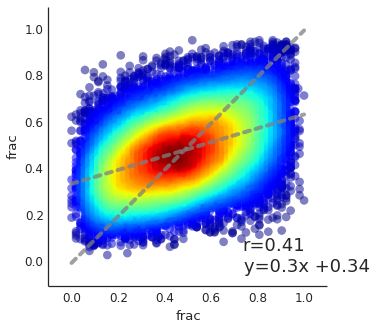

In [249]:
plot_regression(dx_brca.frac.ix[gg], dx_rest.frac, density=True, rad=.1)

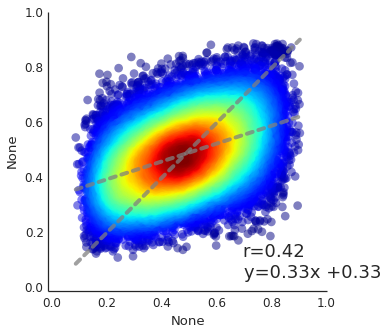

In [292]:
plot_regression(sig_weight.ix[gg], sig_rest, density=True, rad=.1)

In [259]:
(sig_weight.ix[gg] - sig_rest).dropna().order().tail()

TDRD1       0.53
SLC25A42    0.54
SAMD5       0.55
WASF3       0.59
SGEF        0.59
dtype: float64

[Inactivation of the WASF3 gene in prostate cancer cells leads to suppression of tumorigenicity and metastases.](http://www.ncbi.nlm.nih.gov/pubmed/20717117)

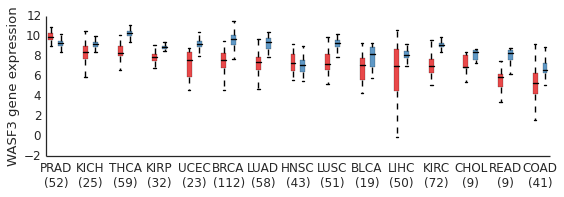

In [257]:
paired_bp_tn_split(matched_rna.ix['WASF3'], codes)

[SGEF is overexpressed in prostate cancer and contributes to prostate cancer progression.](http://www.ncbi.nlm.nih.gov/pubmed/22824926)

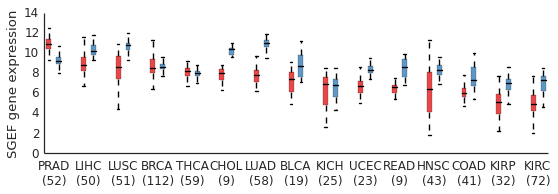

In [255]:
paired_bp_tn_split(matched_rna.ix['SGEF'], codes)